# Analyze RT barcodes in merged 37_30 analysis run

## Library import

In [1]:
## The following code ensures that all functions and init files are reloaded before executions.
%load_ext autoreload
%autoreload 2

In [2]:
## Import the custom library
import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import xdbit_funcs as db

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import json
import seaborn as sns
from tqdm import tqdm
import pandas as pd
import scanpy as sc
from pathlib import Path
import anndata
import string
from mpl_toolkits.axes_grid1 import make_axes_locatable


In [4]:
def well2ind(well):
    """Convert well positions to (zero-based) indices"""
    d = {'A':0,'B':1,'C':2,'D':3,'E':4,'F':5,'G':6,'H':7}
    row = d[well[0]]
    col = int(well[1:])-1
    return [row,col]

def make_plate_overview(well_count):
    # bring the counts per well into a plate layout
    out = np.zeros([8, 12])
    for wellpos in well_count.items():
        xy = well2ind(wellpos[0])
        out[xy[0], xy[1]] = int(wellpos[1])
    return out

# Introduction

There are two possible ways to do the well barcoding:
1. Barcoding on RT primer level after combined lysis of the sections
2. Barcoding on indexing PCR level after separate lysis of the sections

# Spillover between wells

One question that we have to answer here is whether there is any mixing occuring between the wells during lysis or during the channel barcoding steps before. In order to analyze this I barcoded in 37_30 the wells on both the RT primer level and the indexing PCR level and ran the analysis pipeline for each well separately but used the RT primer barcodes of all 9 wells as input into the `barcode_legend.csv`.

## Analyze spillover before UMI demultiplexing

To analyze the spillover on data before the UMI demultiplexing we used the statistics in the `recording_dictionary.json`. However, the final interpretation should be done on the demultiplexed data.

In [5]:
wells_dir = Path("/home/hpc/johannes.wirth/data/experiments/37_30/ReadsToCounts_221118")
well_dirs = sorted(list(wells_dir.glob("*/rna_out/")))
seq_ids = [elem.parent.stem for elem in well_dirs]

In [6]:
seqid_to_wellname = {i: w for i, w in zip(seq_ids, ["A1", "A2", "A3", "B1", "B3", "C1", "C2", "C3"])}

In [7]:
well_names = [seqid_to_wellname[elem] for elem in seq_ids]

In [8]:
well_names

['A1', 'A2', 'A3', 'B1', 'B3', 'C1', 'C2', 'C3']

In [9]:
stats_wells = {w: json.load(open(d / "recording_dictionary.json")) for w, d in zip(well_names, well_dirs)}

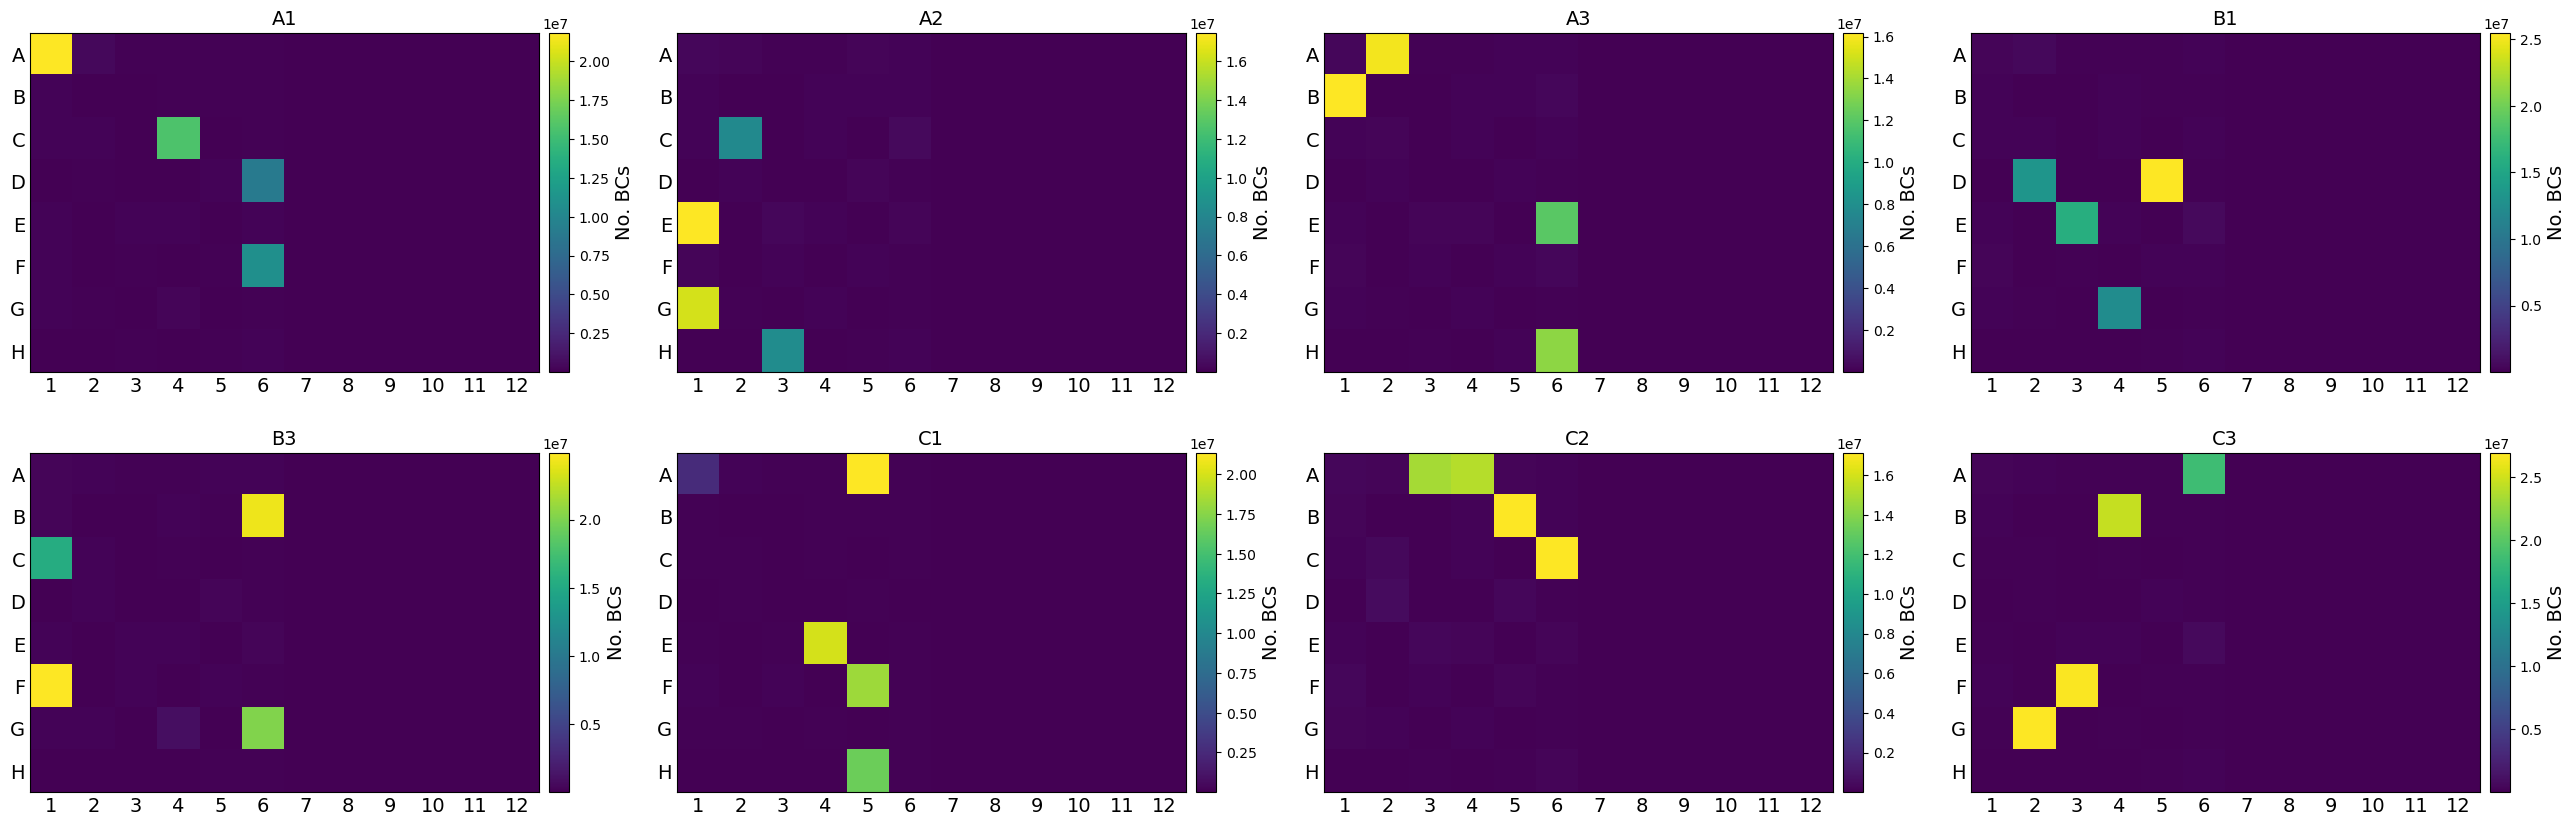

In [10]:
nrows = 2
ncols = 4
fig, axs = plt.subplots(nrows, ncols, figsize=(8*ncols, 5*nrows))
axs = axs.ravel()

for i, (w, stat) in enumerate(stats_wells.items()):
    mtx = make_plate_overview(stat['Z']['well_counts'])
    
    # plot
    p = axs[i].imshow(mtx+1)
    axs[i].set_title(w, fontsize=14)
    
    
    # set x and y ticks
    axs[i].set_xticks(list(range(0, 12)), list(range(1, 13)), fontsize=14)
    axs[i].set_yticks(list(range(0, 8)), list(string.ascii_uppercase[:8]), fontsize=14)
    axs[i].tick_params(axis='both', which='both',length=0)
    
    # set color bar
    # divide axis to fit colorbar
    divider = make_axes_locatable(axs[i])
    cax = divider.append_axes("right", size="4%", pad=0.1)
    clb = fig.colorbar(p, cax=cax)
    clb.set_label('No. BCs', fontsize=14)
    
plt.savefig("figures/spillover_testing/platelayout.pdf")
plt.show()

## Get proportions of correct barcodes from this

In [11]:
barcodes = pd.read_csv("/home/hpc/johannes.wirth/data/experiments/37_30/fastqs/Sample_37_30_A1/barcodes_allRT/barcodes_legend.csv")

In [12]:
bc_to_z = {}
for bc, z in zip(barcodes.WellPosition, barcodes.Z):
    if pd.notna(z):
        z = int(z)
        bc = bc[0] + bc[1:].zfill(2)
        bc_to_z[bc] = z

In [13]:
stat = stats_wells['A1']['Z']['well_counts']

In [14]:
z_counts = {}
for bc, count in stat.items():
    z = bc_to_z[bc]
    c = stat[bc]
    if z not in z_counts:
        z_counts[z] = c
    else:
        z_counts[z] += c

In [15]:
zs = np.unique(list(bc_to_z.values()))
wells = stats_wells.keys()

In [16]:
well_to_id = {w: i for i,w in zip(zs, well_names)}
id_to_well = {i: w for i,w in zip(zs, well_names)}

In [17]:
n_wells = len(wells)
z_counts = pd.DataFrame(
    data={z: [0] * n_wells for z in zs},
    index=zs,
    columns=zs
)

for w in wells:
    stat = stats_wells[w]['Z']['well_counts']
    for bc, count in stat.items():
        z = bc_to_z[bc]
        c = stat[bc]
        z_counts.loc[well_to_id[w], z] += c

In [18]:
z_counts.index = ["well_{}".format(elem) for elem in z_counts.index]

In [19]:
# calculate percentage per well
z_counts = z_counts.T
z_counts = z_counts / z_counts.sum() * 100 # calculate percentage
z_counts = z_counts.T

In [20]:
z_counts

,0,1,2,3,5,6,7,8
well_0,91.953982,1.261095,1.654784,1.438566,1.055738,0.953853,0.774363,0.907619
well_1,1.309675,90.652034,1.447646,1.609074,1.168126,1.321196,1.483717,1.008533
well_2,1.265794,1.015271,92.646567,1.152385,1.306744,1.049190,0.761428,0.802620
well_3,1.353767,1.204690,2.339796,90.802576,1.224238,1.123099,0.966164,0.985670
well_5,0.875528,0.849765,1.207644,1.860586,92.462410,0.970180,0.665022,1.108865
well_6,3.498357,0.539846,0.713435,0.613264,0.642529,92.672686,0.630115,0.689767
well_7,1.042643,1.222934,1.277766,1.833887,1.085042,1.092353,91.424886,1.020490
well_8,0.805659,0.616012,1.294061,0.864864,0.788005,0.770955,0.531433,94.329011


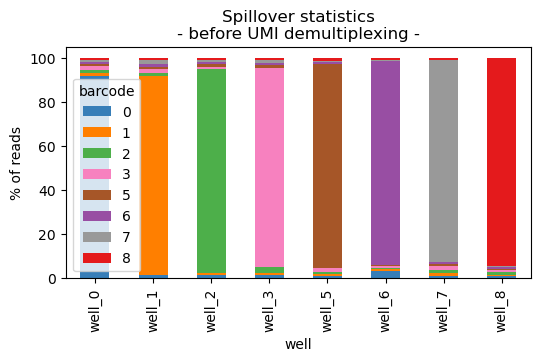

In [21]:
# get own collection of color palettes
custom_color = db.pl.color_palettes()

fig, axs = plt.subplots(1,1, figsize=(6, 3))

z_counts.plot(kind="bar", stacked=True, color=custom_color.colorblind,
              ax=axs)
axs.set_title("Spillover statistics\n- before UMI demultiplexing -")

axs.legend(title='barcode')
axs.set_ylabel("% of reads")
axs.set_xlabel("well")

plt.savefig("figures/spillover_testing/barplot_spillover_before_umidemul.pdf", bbox_inches="tight")
plt.show()

## Analysis 2: After demultiplexing

This can be done from the final `DGE_matrix_with_introns_min100.txt.gz` files.

In [22]:
adatas = {seqid_to_wellname[d.parent.stem]: sc.read_text(d / "DGE_matrix_with_introns_min100.txt.gz").transpose() for d in well_dirs}

In [23]:
adatas

{'A1': AnnData object with n_obs × n_vars = 4483 × 22187,
 'A2': AnnData object with n_obs × n_vars = 4581 × 21266,
 'A3': AnnData object with n_obs × n_vars = 3895 × 22824,
 'B1': AnnData object with n_obs × n_vars = 5799 × 23279,
 'B3': AnnData object with n_obs × n_vars = 5019 × 23189,
 'C1': AnnData object with n_obs × n_vars = 4593 × 22830,
 'C2': AnnData object with n_obs × n_vars = 4882 × 22827,
 'C3': AnnData object with n_obs × n_vars = 5391 × 23774}

In [24]:
perc = {}
for w, adata in adatas.items():
    adata.obs["total_counts"] = adata.X.sum(axis=1).astype(int)
    adata.obs["well"] = [id_to_well[int(elem.split("x")[-1])] for elem in adata.obs_names]
    
    # calculate the sum of counts per well and add to dictionary
    perc[w] = adata.obs.groupby("well").sum().squeeze()

In [25]:
# generate dataframe from dictionary
perc = pd.DataFrame(perc)
perc.columns.name = "barcodes"

In [26]:
# calculate percentage of barcodes per well
perc = perc.div(perc.sum(axis=1), axis=0) * 100

In [27]:
perc

barcodes,A1,A2,A3,B1,B3,C1,C2,C3
well,,,,,,,,
A1,86.437919,1.297117,1.181656,1.831189,1.369442,4.565967,1.356137,1.960574
A2,0.862003,95.836450,0.128433,0.933521,0.751828,0.264254,0.565786,0.657725
A3,0.880147,0.831104,92.158767,1.984400,1.075406,0.809318,0.849971,1.410887
B1,0.560559,0.588291,0.250064,95.294098,1.030852,0.448613,0.846532,0.980991
B3,0.754608,0.931162,0.813905,1.253051,92.285444,1.185809,1.069340,1.706680
C1,1.282323,1.329918,1.192853,1.673259,1.811049,89.045563,1.529574,2.135461
C2,0.866692,1.589681,0.418219,1.230145,1.243033,1.141478,92.065043,1.445709
C3,1.336473,0.954890,0.936440,1.460019,2.440990,1.474476,1.379506,90.017207


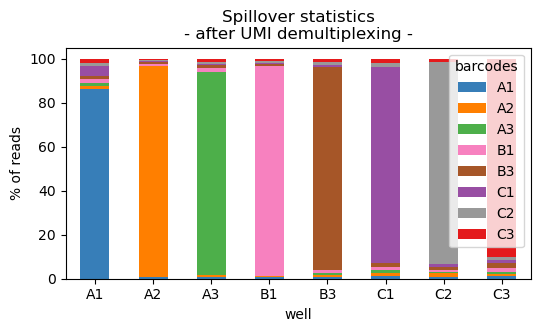

In [28]:
# get own collection of color palettes
custom_color = db.pl.color_palettes()

# plotting
fig, axs = plt.subplots(1,1, figsize=(6, 3))

perc.plot(kind="bar", 
          stacked=True, 
          color=custom_color.colorblind,
          rot=0,
          ax=axs)
axs.set_title("Spillover statistics\n- after UMI demultiplexing -")

axs.set_ylabel("% of reads")
#axs.set_xlabel("well ID")
plt.savefig("figures/spillover_testing/barplot_spillover_after_umidemul.pdf", bbox_inches="tight")
plt.show()

In [31]:
100 - perc.max()

barcodes
A1    13.562081
A2     4.163550
A3     7.841233
B1     4.705902
B3     7.714556
C1    10.954437
C2     7.934957
C3     9.982793
dtype: float64